In [115]:
import os
import random
from sklearn.model_selection import train_test_split
from data_reader import MaldiDataset
import numpy as np
from scipy.spatial.distance import euclidean
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib

In [74]:
# Set all seeds to make the results reproducible
random.seed(42)
np.random.seed(42)


# This script is a simple starting point to classify fungal data using MALDI-TOF spectra.
class SimpleFungusDataLoader:
    def __init__(self, dataset_path, test_size=0.2, random_state=42):
        # Initialize the classifier with dataset path, test size, and random state for reproducibility.
        self.dataset_path = dataset_path
        self.test_size = test_size
        self.random_state = random_state
        self.data = None
        self.train_data = []
        self.test_data = []

    def load_data(self, n_step):
        # Load the dataset using MaldiDataset
        dataset = MaldiDataset(self.dataset_path, n_step=n_step)
        dataset.parse_dataset()  # Parse the dataset from the specified path
        self.data = dataset.get_data()  # Retrieve the parsed data


    def split_data_stratify(self):
        """
        Divide los datos en train y test de forma estratificada según 'genus_species_label',
        asegurando que no haya solapamiento de 'unique_id_label' entre ambos conjuntos.
        Las clases con menos de 2 instancias se asignan directamente al conjunto de entrenamiento.
        """
        # Convertir los datos en un DataFrame
        df = pd.DataFrame(self.data)

        # Agrupar por 'unique_id_label' y seleccionar una clase representativa ('genus_species_label') para cada grupo
        unique_id_groups = df.groupby('unique_id_label').first().reset_index()

        # Identificar las clases con menos de 2 instancias
        class_counts = unique_id_groups['genus_species_label'].value_counts()
        small_classes = class_counts[class_counts < 2].index

        # Separar los grupos con clases pequeñas y el resto
        small_class_groups = unique_id_groups[unique_id_groups['genus_species_label'].isin(small_classes)]
        remaining_groups = unique_id_groups[~unique_id_groups['genus_species_label'].isin(small_classes)]

        # Estratificar las clases restantes
        train_ids, test_ids = train_test_split(
            remaining_groups['unique_id_label'],
            test_size=self.test_size,
            random_state=self.random_state,
            stratify=remaining_groups['genus_species_label']  # Usar 'genus_species_label' como criterio de estratificación
        )

        # Agregar todas las instancias de clases pequeñas al conjunto de entrenamiento
        train_ids = pd.concat([pd.Series(train_ids), small_class_groups['unique_id_label']])

        # Filtrar el DataFrame original para crear los conjuntos de train y test
        self.train_data = df[df['unique_id_label'].isin(train_ids)]  # DataFrame de entrenamiento
        self.test_data = df[df['unique_id_label'].isin(test_ids)]  # DataFrame de prueba

        # Verificar que no haya solapamiento de 'unique_id_label' entre train y test
        train_unique_ids = set(self.train_data['unique_id_label'])
        test_unique_ids = set(self.test_data['unique_id_label'])
        assert len(train_unique_ids.intersection(test_unique_ids)) == 0, "Unique ID labels overlap between train and test"

        # Imprimir estadísticas
        print(f"Number of unique_id_labels in train data: {len(train_unique_ids)}")
        print(f"Number of unique_id_labels in test data: {len(test_unique_ids)}")
        print(f"Number of samples in train data: {len(self.train_data)}")
        print(f"Number of samples in test data: {len(self.test_data)}")
        print(f"Number of classes to predict: {len(self.train_data['genus_species_label'].unique())}")



    def plot_data_distribution(self):
        """
        Grafica la distribución de las clases ('genus_species_label') en los conjuntos de
        entrenamiento y prueba para visualizar las proporciones después de la división estratificada.
        """
        # Contar las etiquetas en los conjuntos de entrenamiento y prueba
        train_counts = self.train_data['genus_species_label'].value_counts()
        test_counts = self.test_data['genus_species_label'].value_counts()

        # Unificar las etiquetas para asegurar que ambas series tengan los mismos índices
        all_labels = pd.Index(train_counts.index).union(test_counts.index)
        train_counts = train_counts.reindex(all_labels, fill_value=0)
        test_counts = test_counts.reindex(all_labels, fill_value=0)

        # Crear gráfico
        x = np.arange(len(all_labels))  # Posiciones de las barras
        width = 0.4  # Ancho de las barras

        plt.figure(figsize=(14, 8))  # Tamaño del gráfico
        plt.bar(x - width / 2, train_counts, width, label='Train', alpha=0.8, color='blue')
        plt.bar(x + width / 2, test_counts, width, label='Test', alpha=0.8, color='orange')

        # Configurar etiquetas y título
        plt.xlabel('Genus+Species Label', fontsize=12)
        plt.ylabel('Number of Samples', fontsize=12)
        plt.title('Distribution of Genus+Species Labels in Train and Test Data', fontsize=14)
        plt.xticks(x, all_labels, rotation=90, fontsize=10)  # Etiquetas en el eje X
        plt.legend(fontsize=12)

        # Ajustar diseño
        plt.tight_layout()
        plt.grid(axis='y', linestyle='--', alpha=0.6)
    
    def get_train_data(self):
        return self.train_data
    
    def get_test_data(self):
        return self.test_data
    

        


In [83]:
# Define the dataset path (update this path to where your dataset is located)
dataset_path = "data/fungus_db"

# Initialize the classifier with the dataset path
fungus_identifier = SimpleFungusDataLoader(dataset_path)

fungus_identifier.load_data(n_step=6)

# Load and split the data into training and test sets.
fungus_identifier.split_data_stratify()

332
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping n

c:\Users\aleta\Documents\TFM\FungusClassifier\data_reader.py:301: RuntimeWarning: invalid value encountered in divide
  intensity=SpectrumObj.intensity / SpectrumObj.intensity.sum() * self.sum,


Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
258
259
260
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
Number of unique_id_labels in train data: 268
Number of unique_id_labels in test data: 64
Number of samples in train data: 6452
Number of samples in test data: 1476
Number of classes to predict: 60


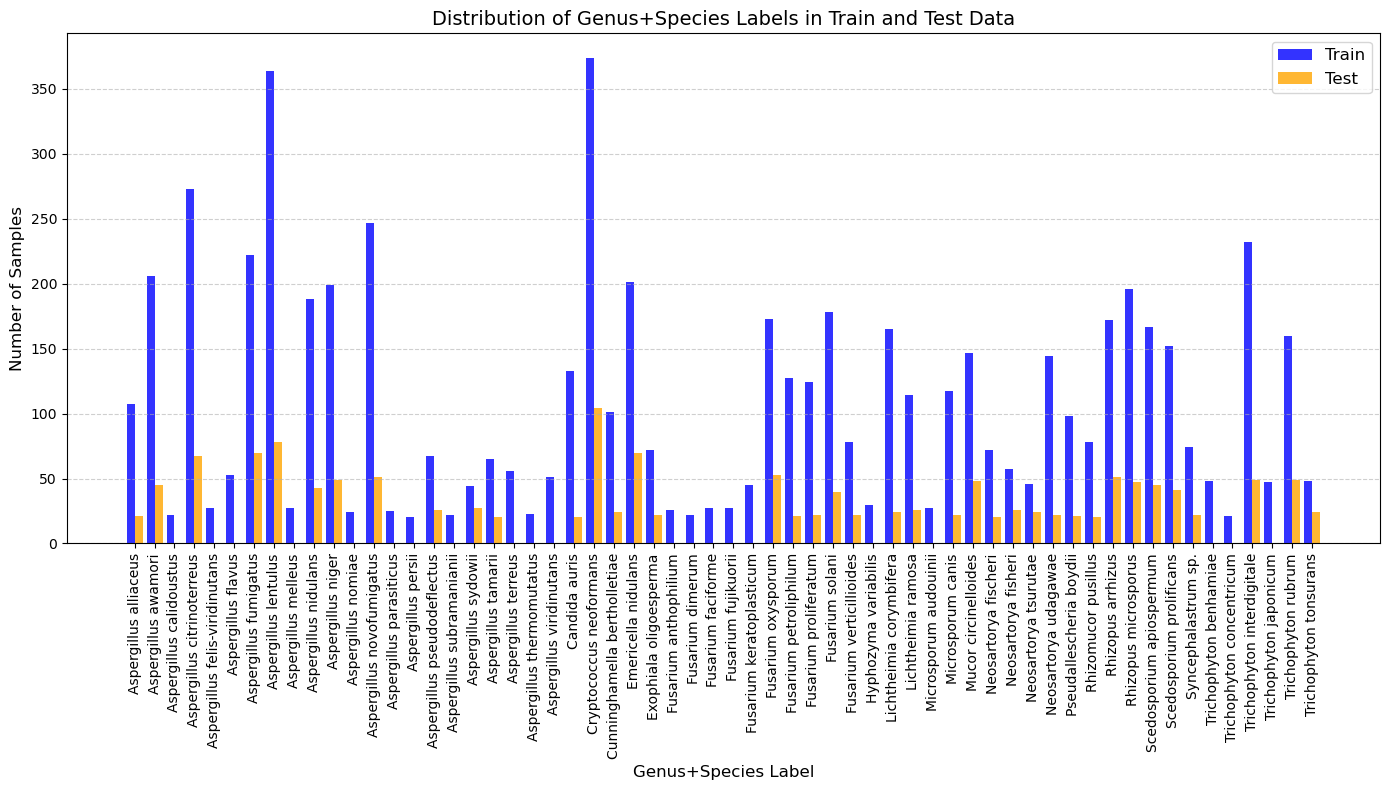

In [5]:
fungus_identifier.plot_data_distribution()

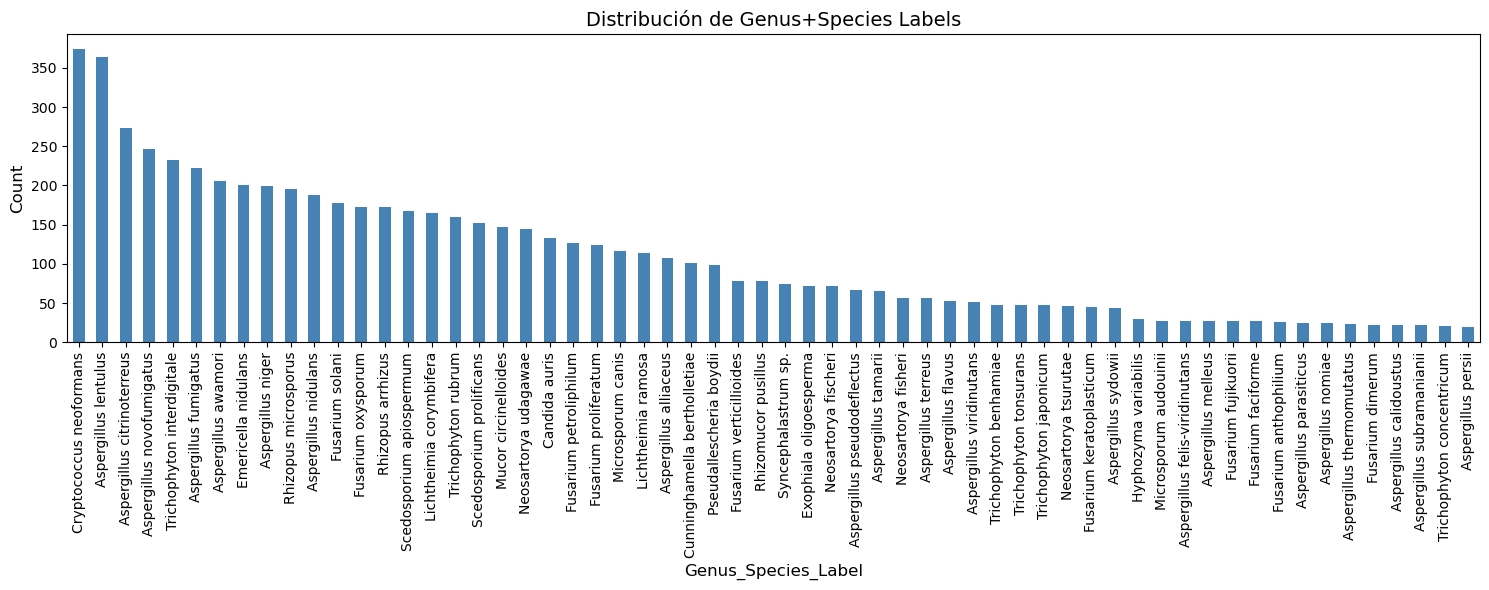

In [8]:
# Crear el gráfico de barras
plt.figure(figsize=(15, 6))  # Ajustar el tamaño del gráfico
fungus_identifier.train_data['genus_species_label'].value_counts().plot(kind='bar', color='steelblue')

# Rotar las etiquetas del eje X para que no se solapen
plt.xticks(rotation=90, fontsize=10)  # Rotar 90 grados y ajustar el tamaño de fuente

# Agregar etiquetas y título
plt.xlabel('Genus_Species_Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribución de Genus+Species Labels', fontsize=14)

# Ajustar el diseño para evitar solapamiento
plt.tight_layout()

# Mostrar el gráfico
plt.show()


<Axes: xlabel='genus_label'>

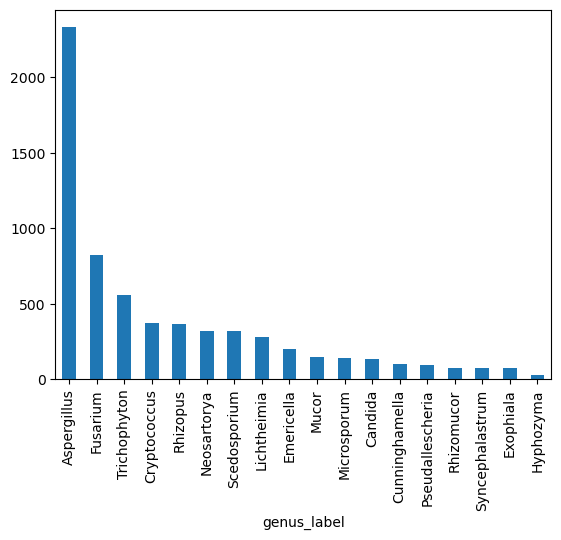

In [9]:
fungus_identifier.train_data['genus_label'].value_counts().plot(kind='bar')

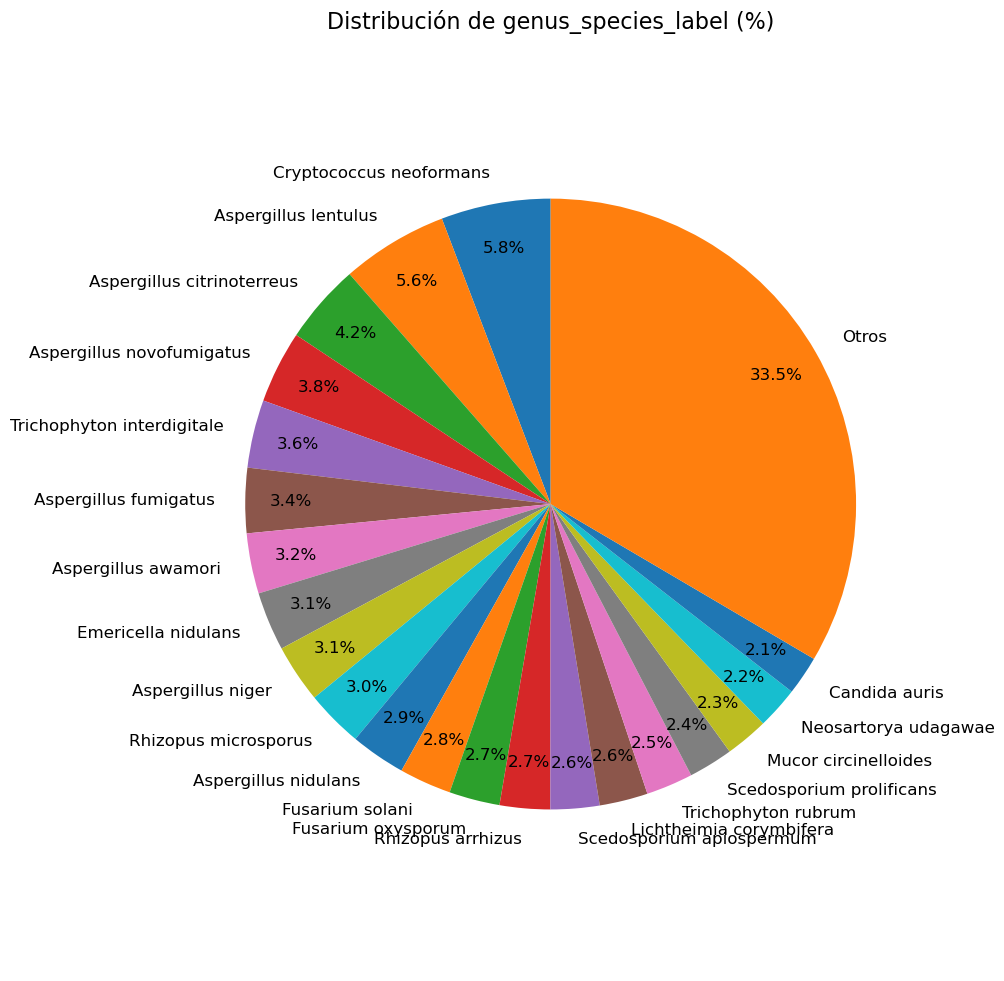

In [10]:
# Calcular los conteos y porcentajes
value_counts = fungus_identifier.train_data['genus_species_label'].value_counts()
percentages = value_counts / value_counts.sum() * 100

# Agrupar categorías pequeñas
threshold = 2  # Porcentaje mínimo para mostrar individualmente
large_categories = percentages[percentages >= threshold]
small_categories = percentages[percentages < threshold].sum()
percentages_filtered = pd.concat([large_categories, pd.Series({'Otros': small_categories})])

# Crear el gráfico circular con líneas de conexión
plt.figure(figsize=(10, 10))  # Aumentar el tamaño del gráfico
plt.pie(
    percentages_filtered,
    labels=percentages_filtered.index,
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 12},
    pctdistance=0.85,  # Porcentajes más cerca del centro
    labeldistance=1.1  # Etiquetas más alejadas del centro
)
plt.title('Distribución de genus_species_label (%)', fontsize=16)
plt.axis('equal')  # Asegurar que el gráfico sea circular
plt.tight_layout()  # Ajustar elementos automáticamente
plt.show()

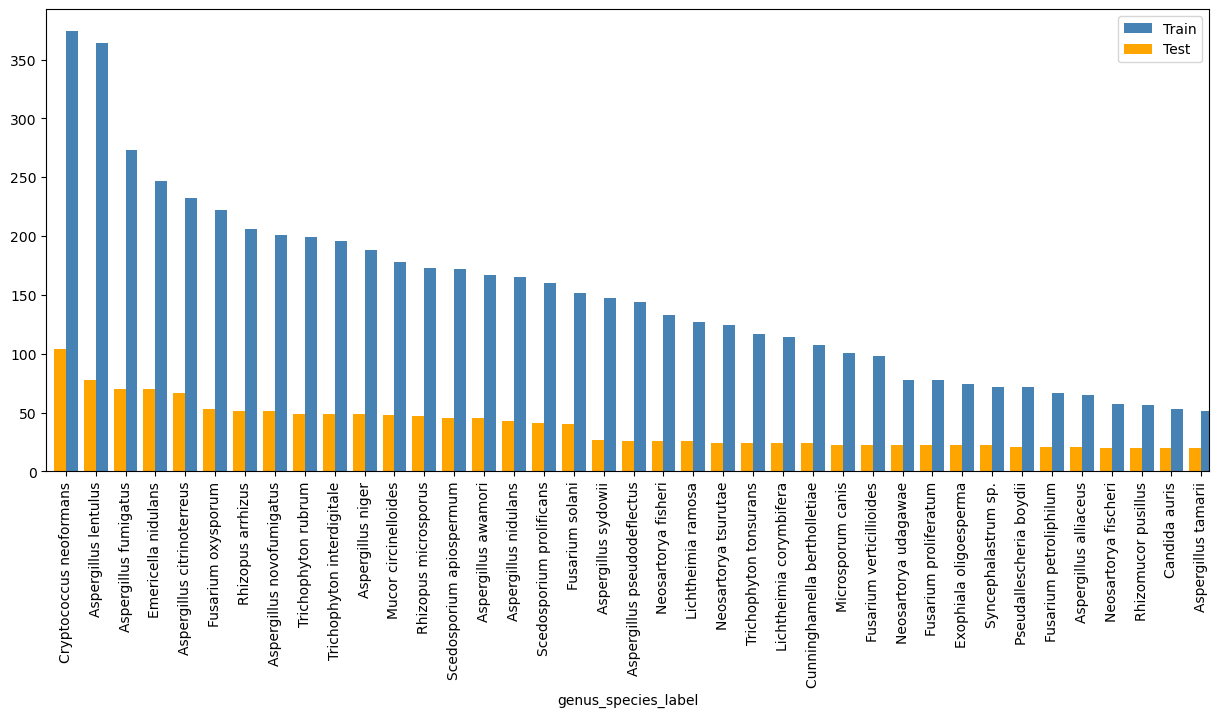

In [11]:
#Comparar la distribución de las etiquetas en los conjuntos de entrenamiento y prueba
plt.figure(figsize=(15, 6))  # Ajustar el tamaño del gráfico
fungus_identifier.train_data['genus_species_label'].value_counts().plot(kind='bar', color='steelblue', position=0, width=0.4, label='Train')
fungus_identifier.test_data['genus_species_label'].value_counts().plot(kind='bar', color='orange', position=1, width=0.4, label='Test')
plt.legend()

In [84]:
train_data = fungus_identifier.get_train_data()
test_data = fungus_identifier.get_test_data()

In [88]:
label_encoder_genus = LabelEncoder()
label_encoder_genus_species = LabelEncoder()
train_data['genus_species_label'] = label_encoder_genus_species.fit_transform(train_data['genus_species_label'])
train_data['genus_label'] = label_encoder_genus.fit_transform(train_data['genus_label'])
test_data['genus_species_label'] = label_encoder_genus_species.transform(test_data['genus_species_label'])
test_data['genus_label'] = label_encoder_genus.transform(test_data['genus_label'])

spectra_normalized = []
for spectrum in train_data['spectrum']:
    scaler = StandardScaler()
    # Asegurar que el spectrum sea un array 2D
    spectrum_2d = np.array(spectrum).reshape(-1, 1)
    spectrum_normalized = scaler.fit_transform(spectrum_2d).flatten()  # Reducir a 1D nuevamente
    spectra_normalized.append(spectrum_normalized)
train_data['spectrum'] = spectra_normalized

spectra_normalized = []
for spectrum in test_data['spectrum']:
    scaler = StandardScaler()
    # Asegurar que el spectrum sea un array 2D
    spectrum_2d = np.array(spectrum).reshape(-1, 1)
    spectrum_normalized = scaler.fit_transform(spectrum_2d).flatten()  # Reducir a 1D nuevamente
    spectra_normalized.append(spectrum_normalized)
test_data['spectrum'] = spectra_normalized

In [91]:
x_train = train_data.drop(columns=['genus_species_label', 'genus_label', 'unique_id_label','m/z'])
genus_label_train = train_data['genus_label']
genus_species_label_train = train_data['genus_species_label']
x_test = test_data.drop(columns=['genus_species_label', 'genus_label', 'unique_id_label','m/z'])
genus_label_test = test_data['genus_label']
genus_species_label_test = test_data['genus_species_label']


In [112]:
def evaluate_knn_classifier(x_test, y_test, knn_classifier, classes=None, figsize=(20, 20), fontsize=8, zero_division=0):
    """
    Evalúa un clasificador KNN en datos de prueba e incluye métricas detalladas, 
    además de graficar la matriz de confusión con tamaño ajustable.

    Parameters:
        x_test (np.array): Conjunto de datos de prueba.
        y_test (np.array or pd.Series): Etiquetas verdaderas correspondientes al conjunto de prueba.
        knn_classifier (KNeighborsClassifier): Modelo KNN previamente entrenado.
        classes (list, optional): Lista de clases para las etiquetas. Si no se proporciona, se usan etiquetas únicas de `y_test`.
        figsize (tuple, optional): Tamaño del gráfico de la matriz de confusión.
        fontsize (int, optional): Tamaño de la fuente para las etiquetas de la matriz de confusión.
        zero_division (int, optional): Controla cómo manejar métricas indeterminadas. Default: 0.
    
    Returns:
        dict: Diccionario con precisión, etiquetas predichas, y etiquetas verdaderas.
    """
    # Predicciones del clasificador
    y_pred = knn_classifier.predict(x_test)
    
    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    print(f"KNN Classifier Accuracy: {accuracy:.2f}")
    
    print("\nClassification Report:")
    print(
        classification_report(
            y_test, 
            y_pred, 
            target_names=classes, 
            zero_division=zero_division  # Evitar el warning
        )
    )
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)
    
    # Graficar la matriz de confusión
    fig, ax = plt.subplots(figsize=figsize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap="Blues", ax=ax, colorbar=True)
    
    # Ajustar etiquetas y título
    plt.xticks(fontsize=fontsize, rotation=90)
    plt.yticks(fontsize=fontsize)
    plt.title("Confusion Matrix", fontsize=fontsize + 4)
    plt.tight_layout()
    plt.show()

    return {
        'accuracy': accuracy,
        'predicted_labels': y_pred,
        'true_labels': y_test
    }


# BASELINE: KNN

## KNN con n_neighbors aleatorio

In [98]:
spectrum = np.array(train_data['spectrum'].tolist())
knn_genus_level = KNeighborsClassifier(n_neighbors=5)
knn_genus_level.fit(spectrum, genus_label_train)
knn_genus_species_level = KNeighborsClassifier(n_neighbors=5)
knn_genus_species_level.fit(spectrum, genus_species_label_train)

KNeighborsClassifier()

---------------------------- EVALUACIÓN A NIVEL DE GÉNERO -----------------------------------
KNN Classifier Accuracy: 0.96

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       497
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00       104
           3       1.00      1.00      1.00        24
           4       1.00      1.00      1.00        70
           5       1.00      1.00      1.00        22
           6       1.00      1.00      1.00       158
           8       1.00      1.00      1.00        50
           9       1.00      1.00      1.00        22
          10       1.00      1.00      1.00        48
          11       1.00      0.50      0.67        92
          12       1.00      1.00      1.00        21
          13       0.00      0.00      0.00        20
          14       0.83      1.00      0.91        98
          15       1.00      1.00      1.

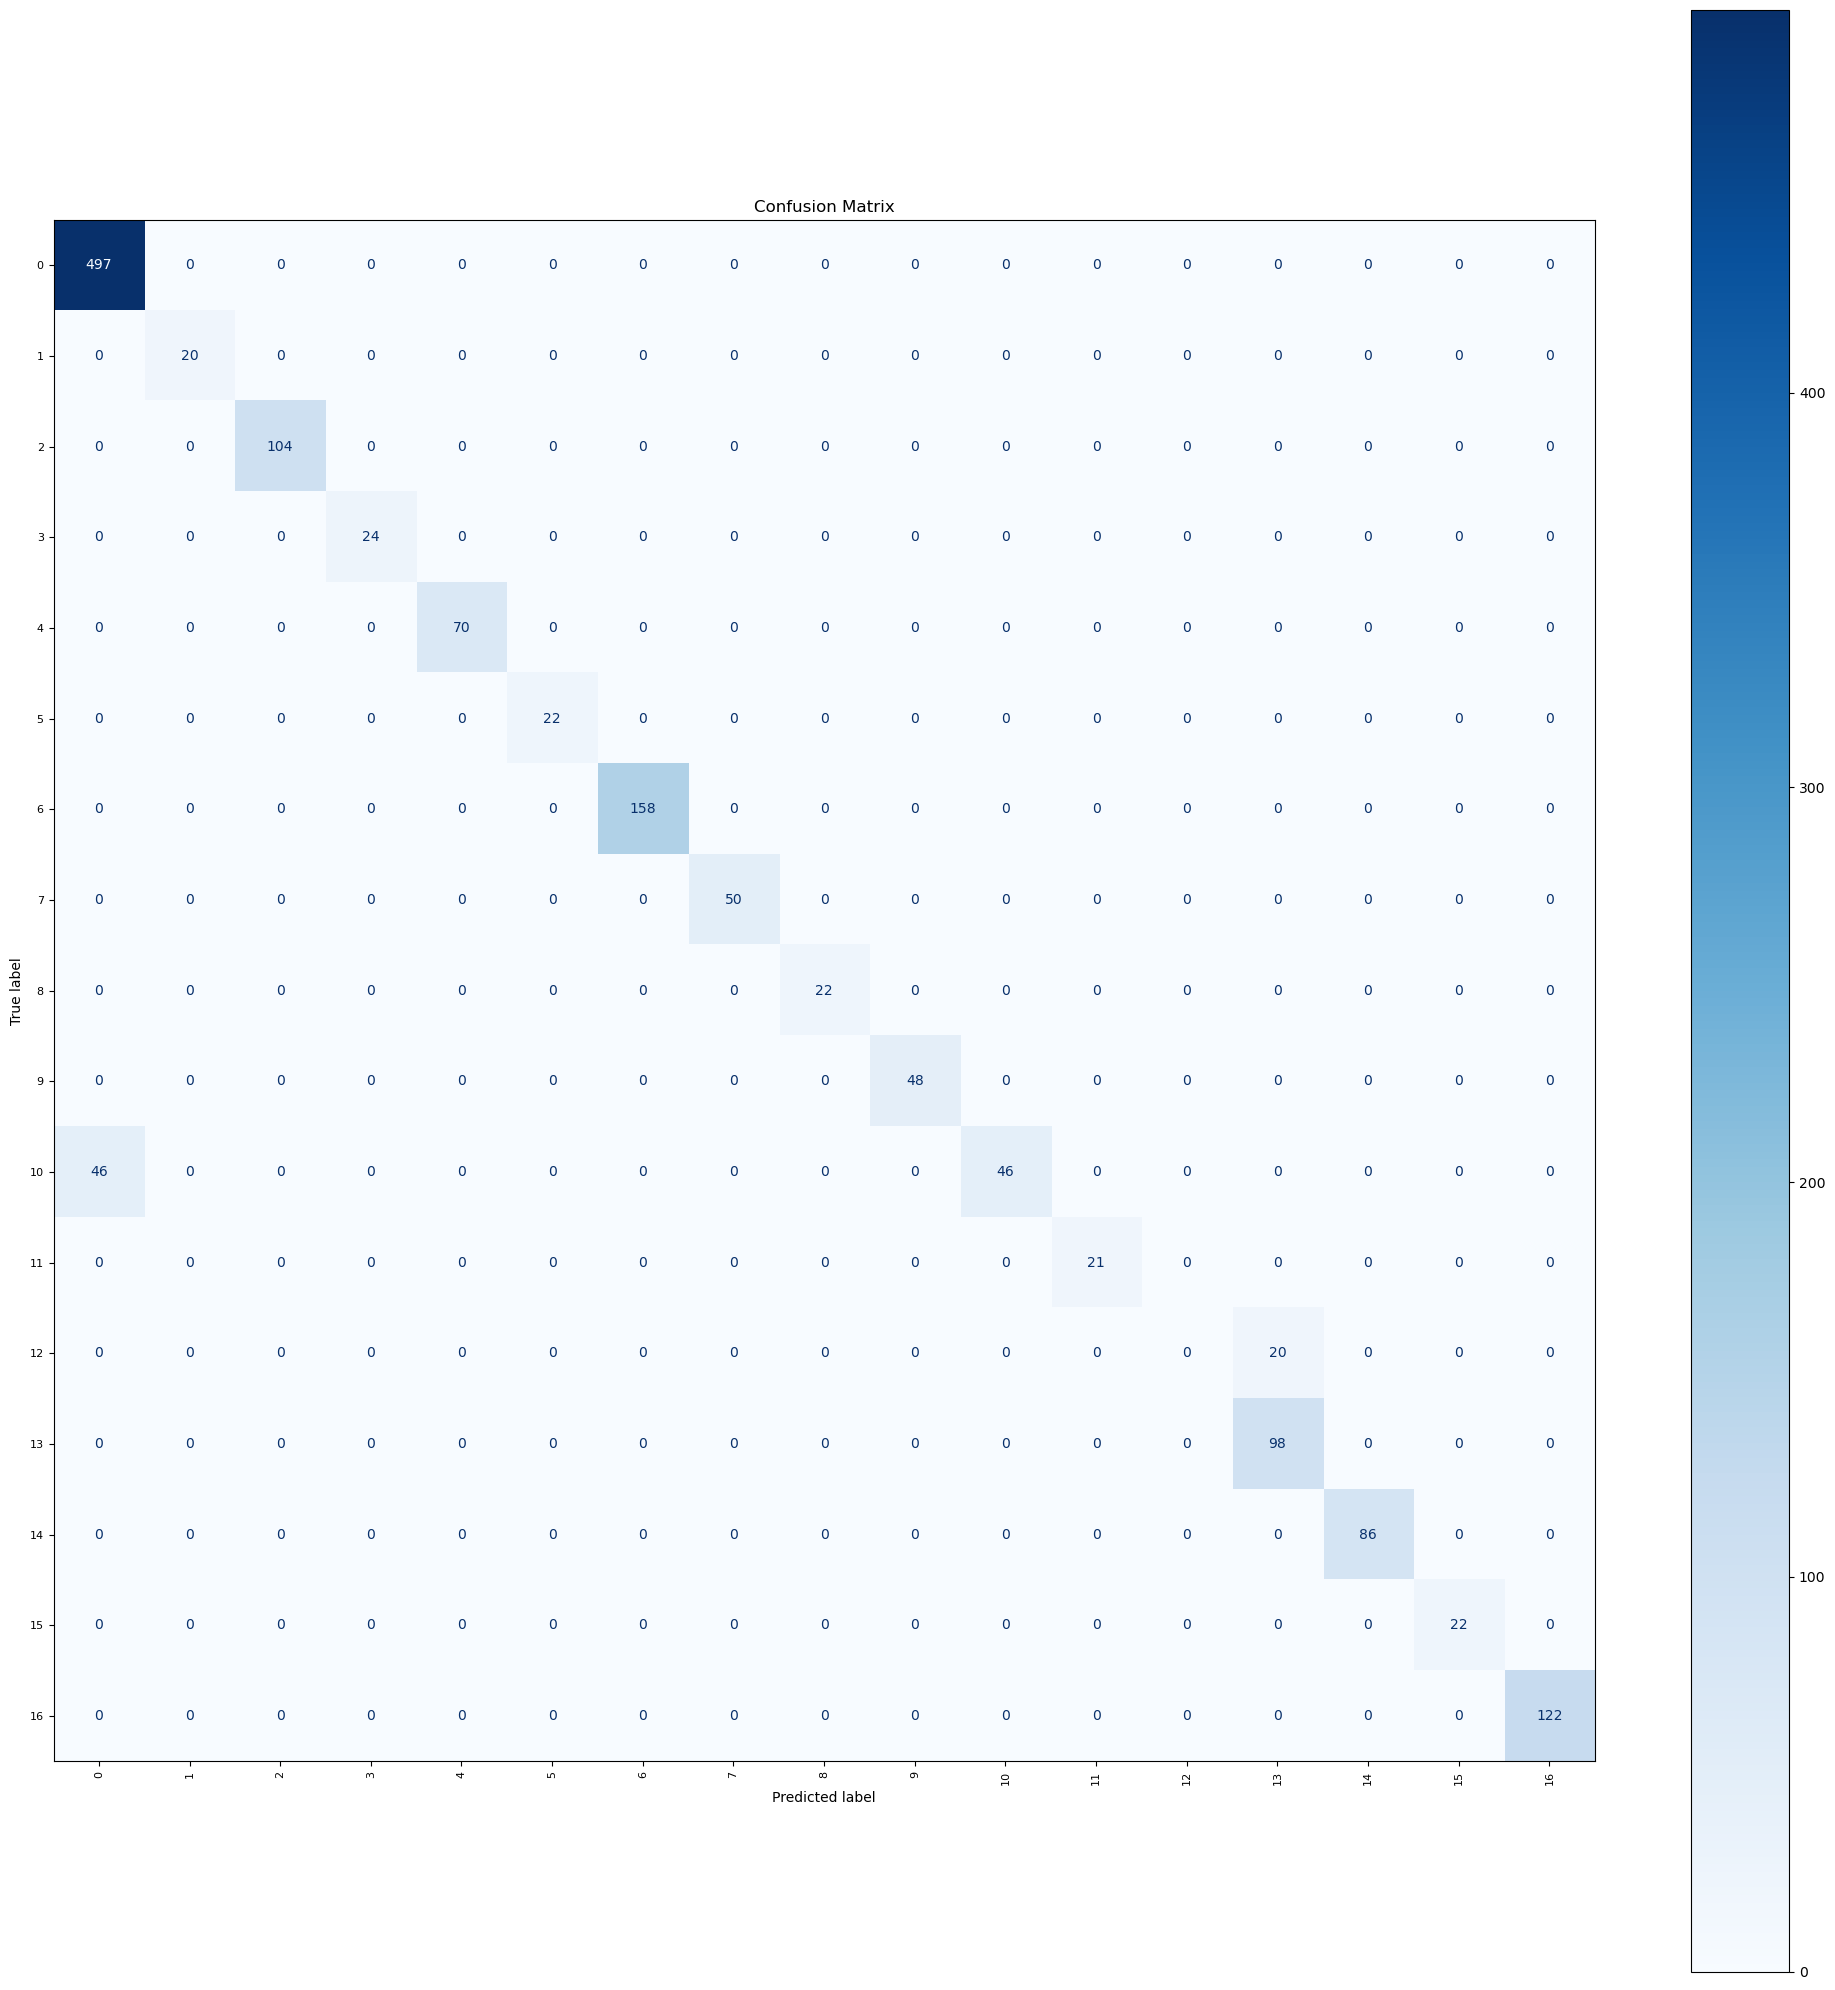

---------------------------- EVALUACIÓN A NIVEL DE GÉNERO Y ESPECIE -----------------------------------
KNN Classifier Accuracy: 0.91

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      0.31      0.47        45
           3       1.00      1.00      1.00        67
           6       1.00      1.00      1.00        70
           7       1.00      1.00      1.00        78
           9       1.00      1.00      1.00        43
          10       0.61      1.00      0.76        49
          12       1.00      1.00      1.00        51
          15       1.00      1.00      1.00        26
          17       1.00      1.00      1.00        27
          18       1.00      1.00      1.00        20
          20       0.00      0.00      0.00         0
          21       0.00      0.00      0.00         0
          22       1.00      1.00      1.00        20
          23       1.00      1.

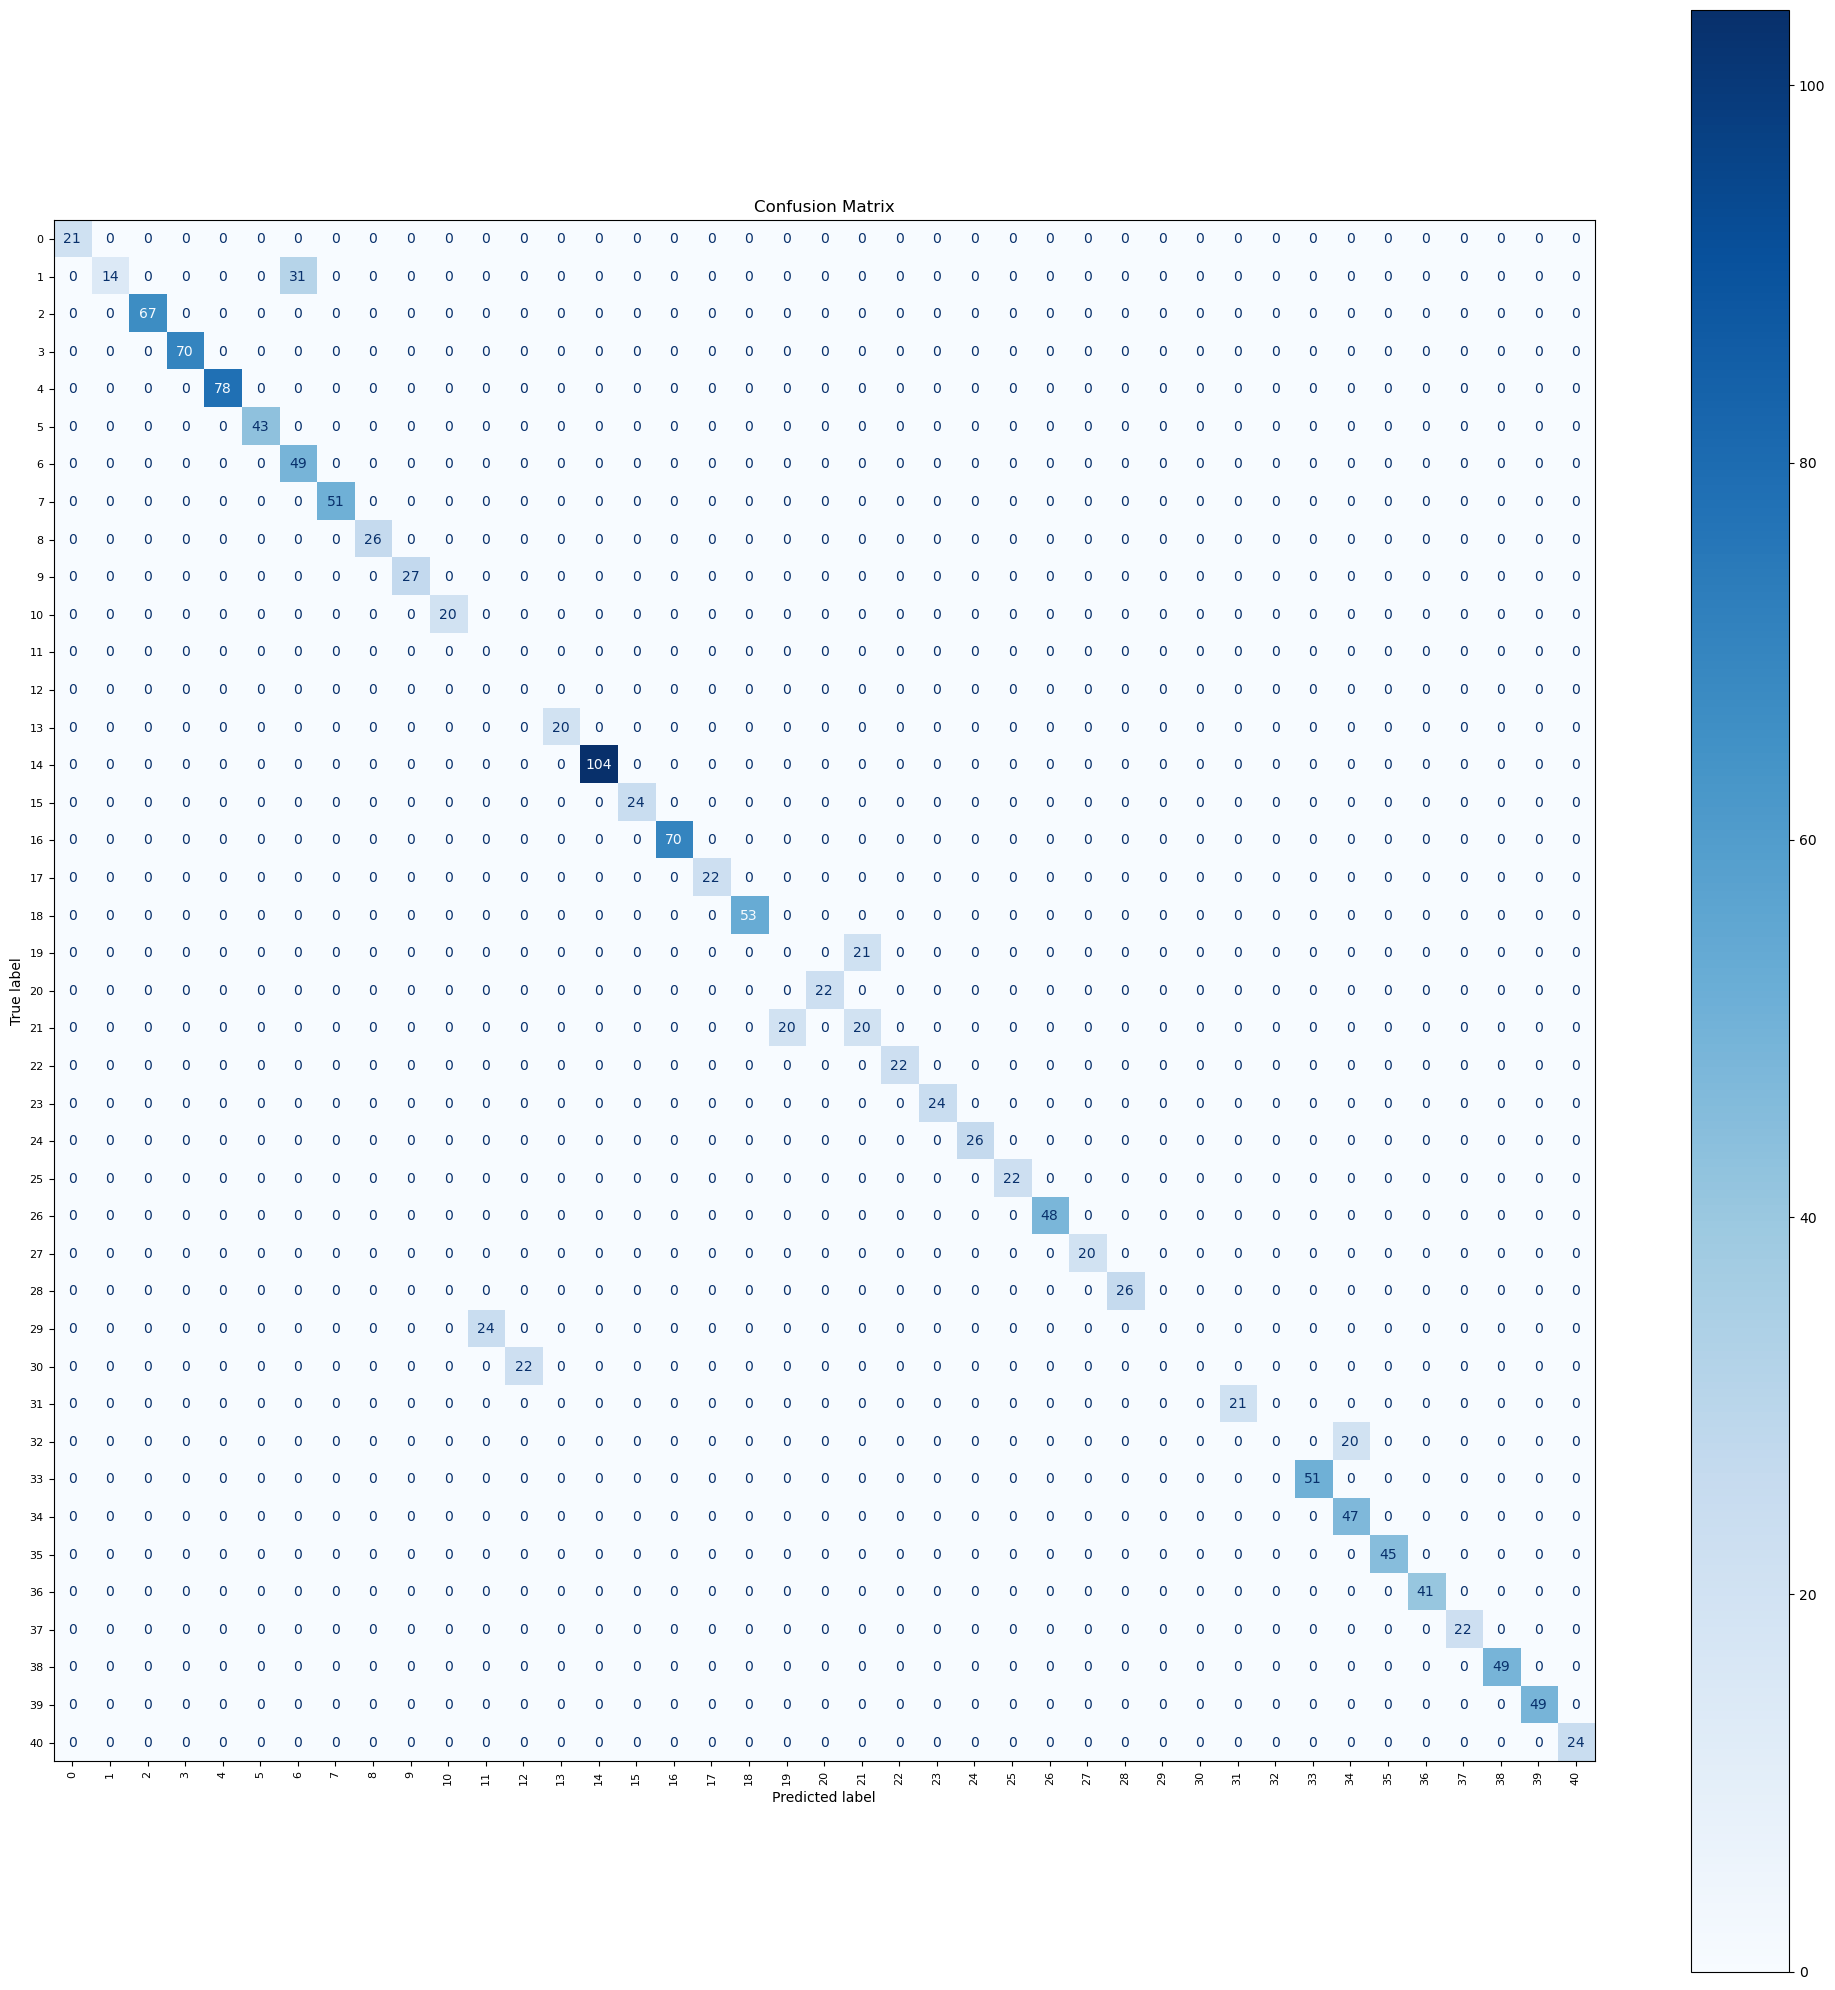

{'accuracy': 0.9065040650406504,
 'predicted_labels': array([ 0,  0,  0, ..., 59, 59, 59], dtype=int64),
 'true_labels': 86       0
 87       0
 88       0
 89       0
 90       0
         ..
 7875    59
 7876    59
 7877    59
 7878    59
 7879    59
 Name: genus_species_label, Length: 1476, dtype: int64}

In [113]:
spectrum_test = np.array(test_data['spectrum'].tolist())
print("---------------------------- EVALUACIÓN A NIVEL DE GÉNERO -----------------------------------")
evaluate_knn_classifier(spectrum_test, genus_label_test, knn_genus_level)
print("---------------------------- EVALUACIÓN A NIVEL DE GÉNERO Y ESPECIE -----------------------------------")
evaluate_knn_classifier(spectrum_test, genus_species_label_test, knn_genus_species_level)

## Aplicando grid search en busca de los mejores híper parámetros

In [122]:
param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev'],
    'algorithm': ['auto','ball_tree', 'brute']
}

In [123]:
grid_search = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    cv=4,  # Validación cruzada
    scoring='accuracy',  # Métrica principal
    verbose=3,  # Mostrar progreso
    n_jobs=-1  # Usar todos los núcleos disponibles
)

# Ajustar el modelo con los datos ya normalizados
grid_search.fit(spectrum, genus_species_label_train)

# Resultados del mejor modelo
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validated Score:", grid_search.best_score_)

Fitting 4 folds for each of 54 candidates, totalling 216 fits
Best Parameters: {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Best Cross-Validated Score: 0.9597024178549287


In [124]:
joblib.dump(grid_search, "grid_search_knn.pkl")

['grid_search_knn.pkl']

In [128]:
knn_best = grid_search.best_estimator_
knn_best.fit(spectrum, genus_species_label_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')

---------------------------- EVALUACIÓN A NIVEL DE GÉNERO Y ESPECIE -----------------------------------
KNN Classifier Accuracy: 0.92

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      0.51      0.68        45
           3       1.00      1.00      1.00        67
           6       1.00      1.00      1.00        70
           7       1.00      1.00      1.00        78
           9       1.00      1.00      1.00        43
          10       0.69      1.00      0.82        49
          12       0.68      1.00      0.81        51
          15       1.00      1.00      1.00        26
          17       1.00      1.00      1.00        27
          18       1.00      1.00      1.00        20
          21       0.00      0.00      0.00         0
          22       1.00      1.00      1.00        20
          23       1.00      1.00      1.00       104
          24       1.00      1.

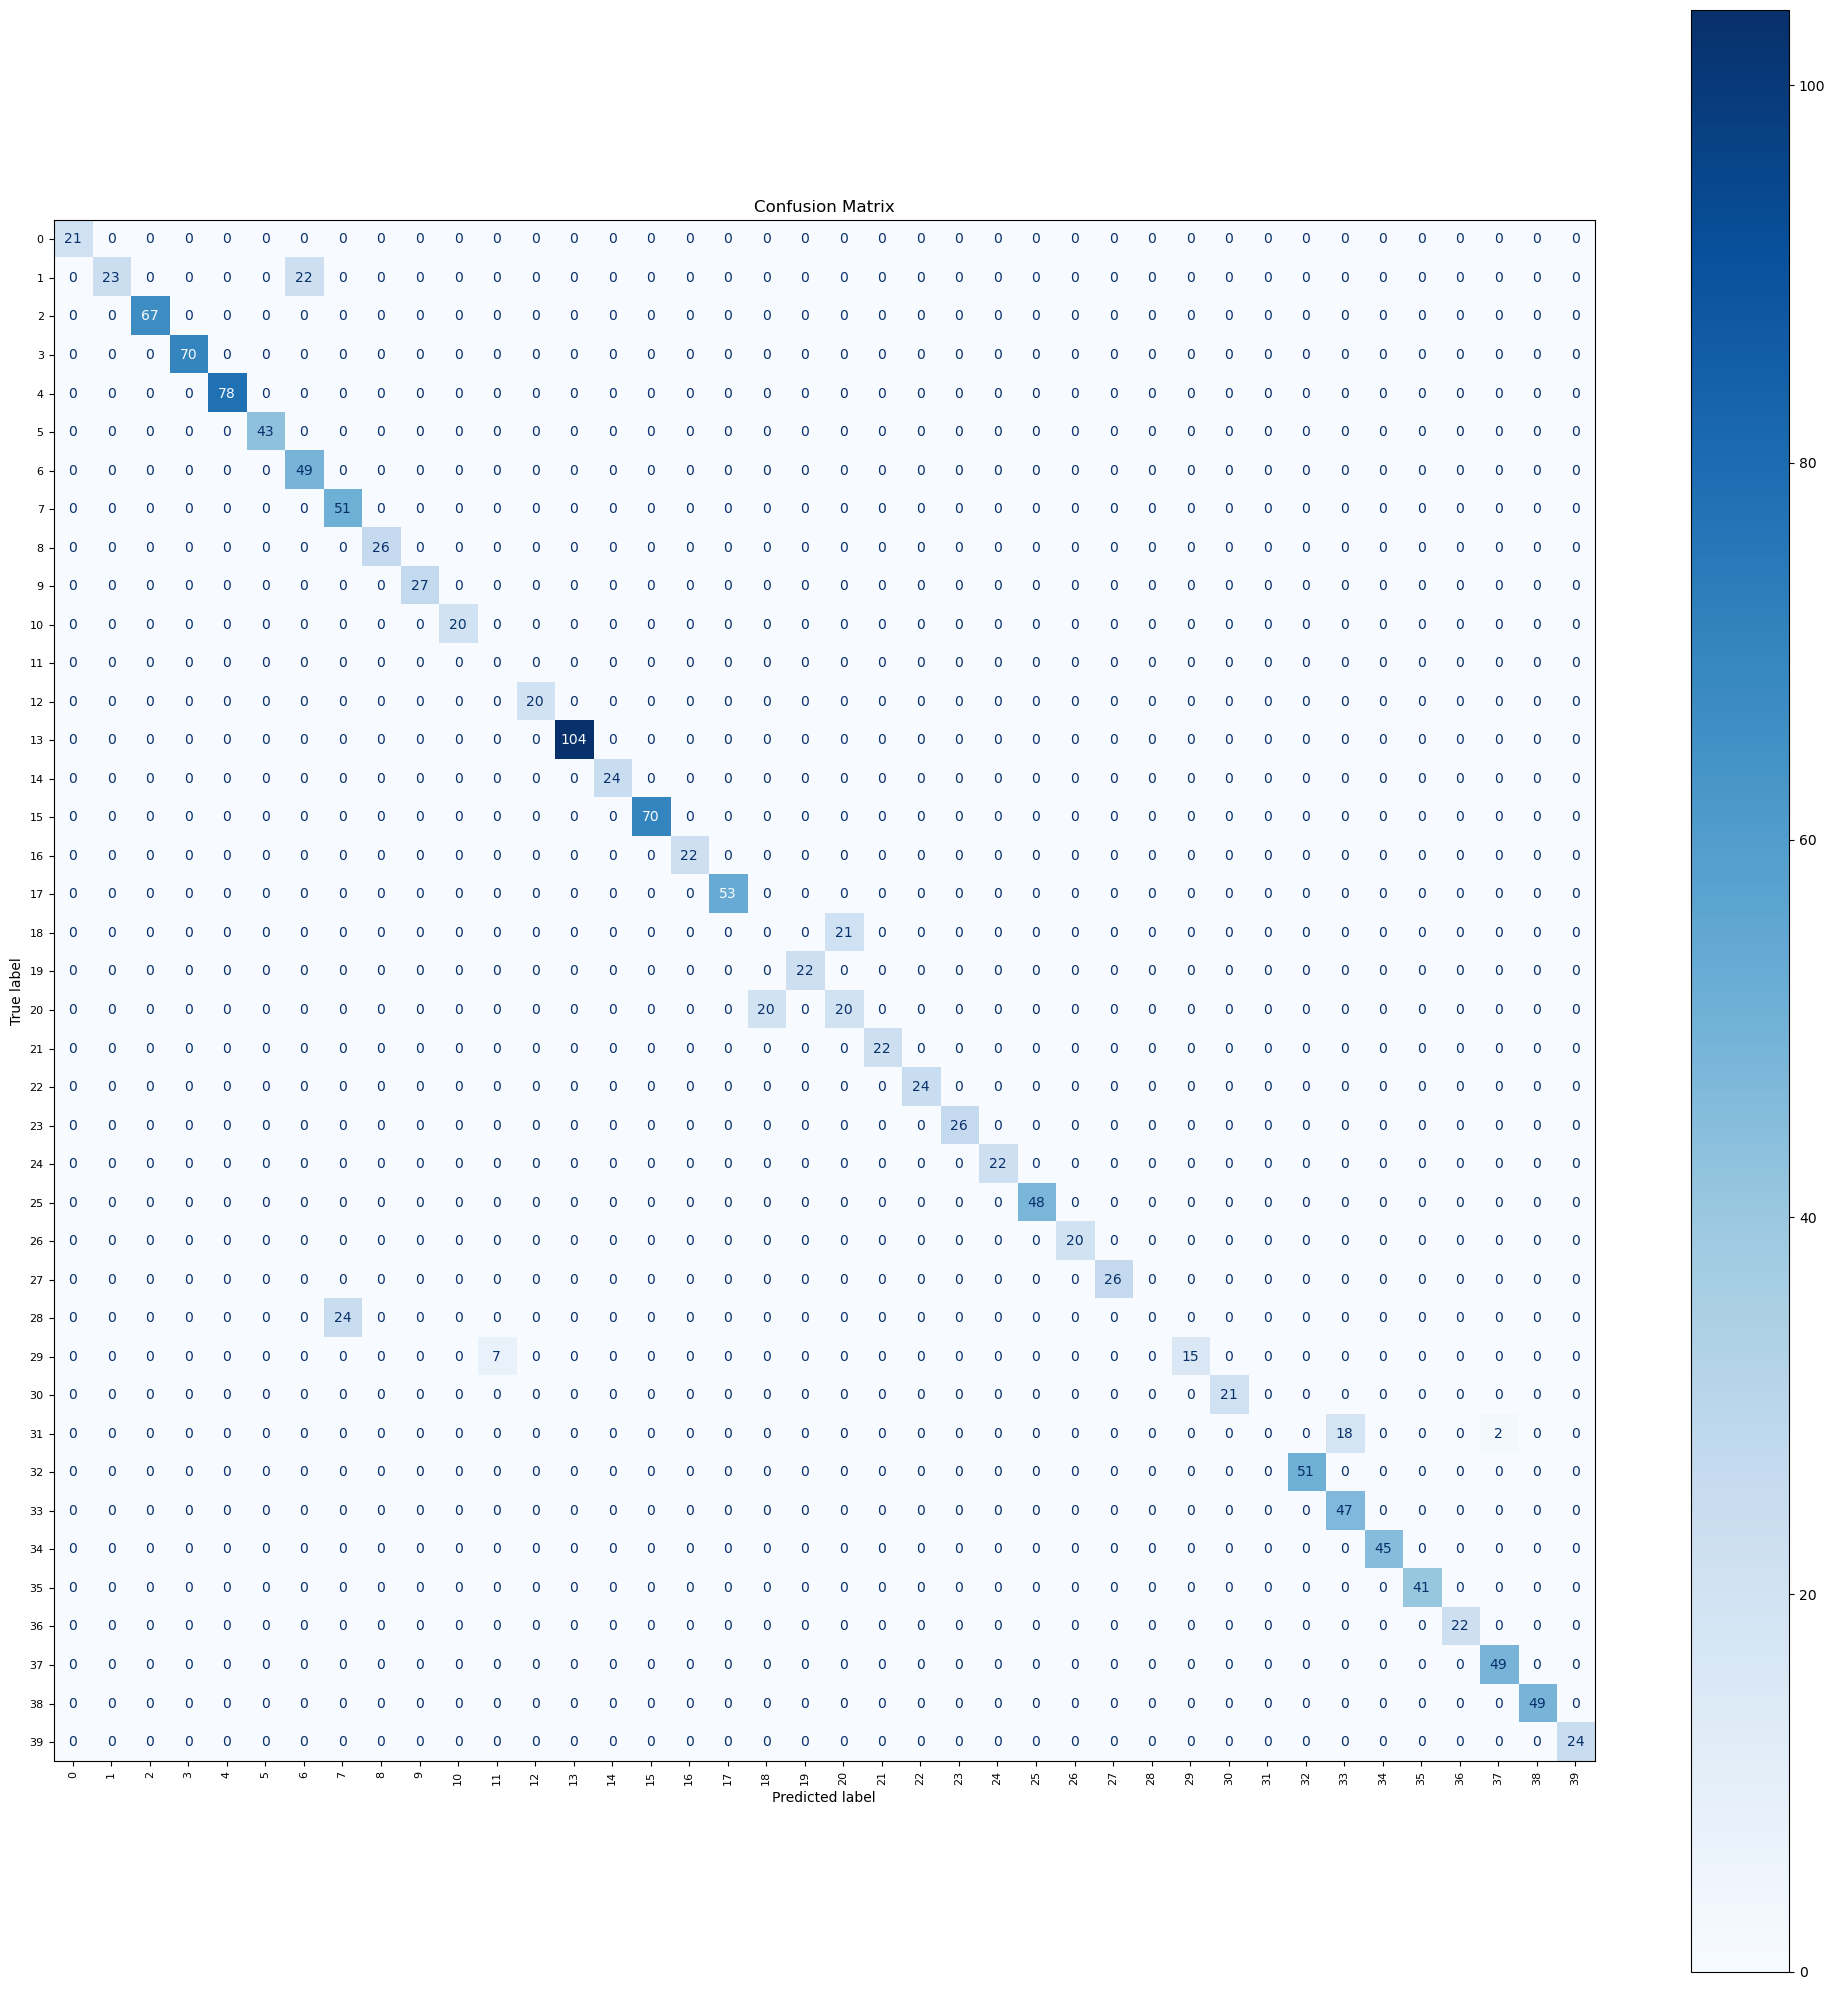

{'accuracy': 0.9227642276422764,
 'predicted_labels': array([ 0,  0,  0, ..., 59, 59, 59], dtype=int64),
 'true_labels': 86       0
 87       0
 88       0
 89       0
 90       0
         ..
 7875    59
 7876    59
 7877    59
 7878    59
 7879    59
 Name: genus_species_label, Length: 1476, dtype: int64}

In [129]:
print("---------------------------- EVALUACIÓN A NIVEL DE GÉNERO Y ESPECIE -----------------------------------")
evaluate_knn_classifier(spectrum_test, genus_species_label_test, knn_best)

## Usando SMOTE

In [101]:
train_data_for_SMOTE = train_data.copy().drop(columns=['genus_species_label', 'genus_label', 'unique_id_label','m/z'])
test_data_for_SMOTE = test_data.copy().drop(columns=['genus_species_label', 'genus_label', 'unique_id_label','m/z'])

In [105]:
spectrum_train_for_SMOTE = np.array(train_data_for_SMOTE['spectrum'].tolist())
smote = SMOTE(random_state=42)
x_train_smote, genus_species_smote = smote.fit_resample(spectrum_train_for_SMOTE, genus_species_label_train)

In [107]:
knn_genus_species_level_smote = KNeighborsClassifier(n_neighbors=5)
knn_genus_species_level_smote.fit(x_train_smote, genus_species_smote)

KNeighborsClassifier()

---------------------------- EVALUACIÓN A NIVEL DE GÉNERO Y ESPECIE CON SMOTE -----------------------------------
KNN Classifier Accuracy: 0.90

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      0.24      0.39        45
           3       1.00      1.00      1.00        67
           6       1.00      1.00      1.00        70
           7       1.00      1.00      1.00        78
           9       1.00      1.00      1.00        43
          10       0.59      1.00      0.74        49
          12       1.00      1.00      1.00        51
          15       1.00      1.00      1.00        26
          17       1.00      1.00      1.00        27
          18       1.00      1.00      1.00        20
          20       0.00      0.00      0.00         0
          21       0.00      0.00      0.00         0
          22       1.00      1.00      1.00        20
          23       1.

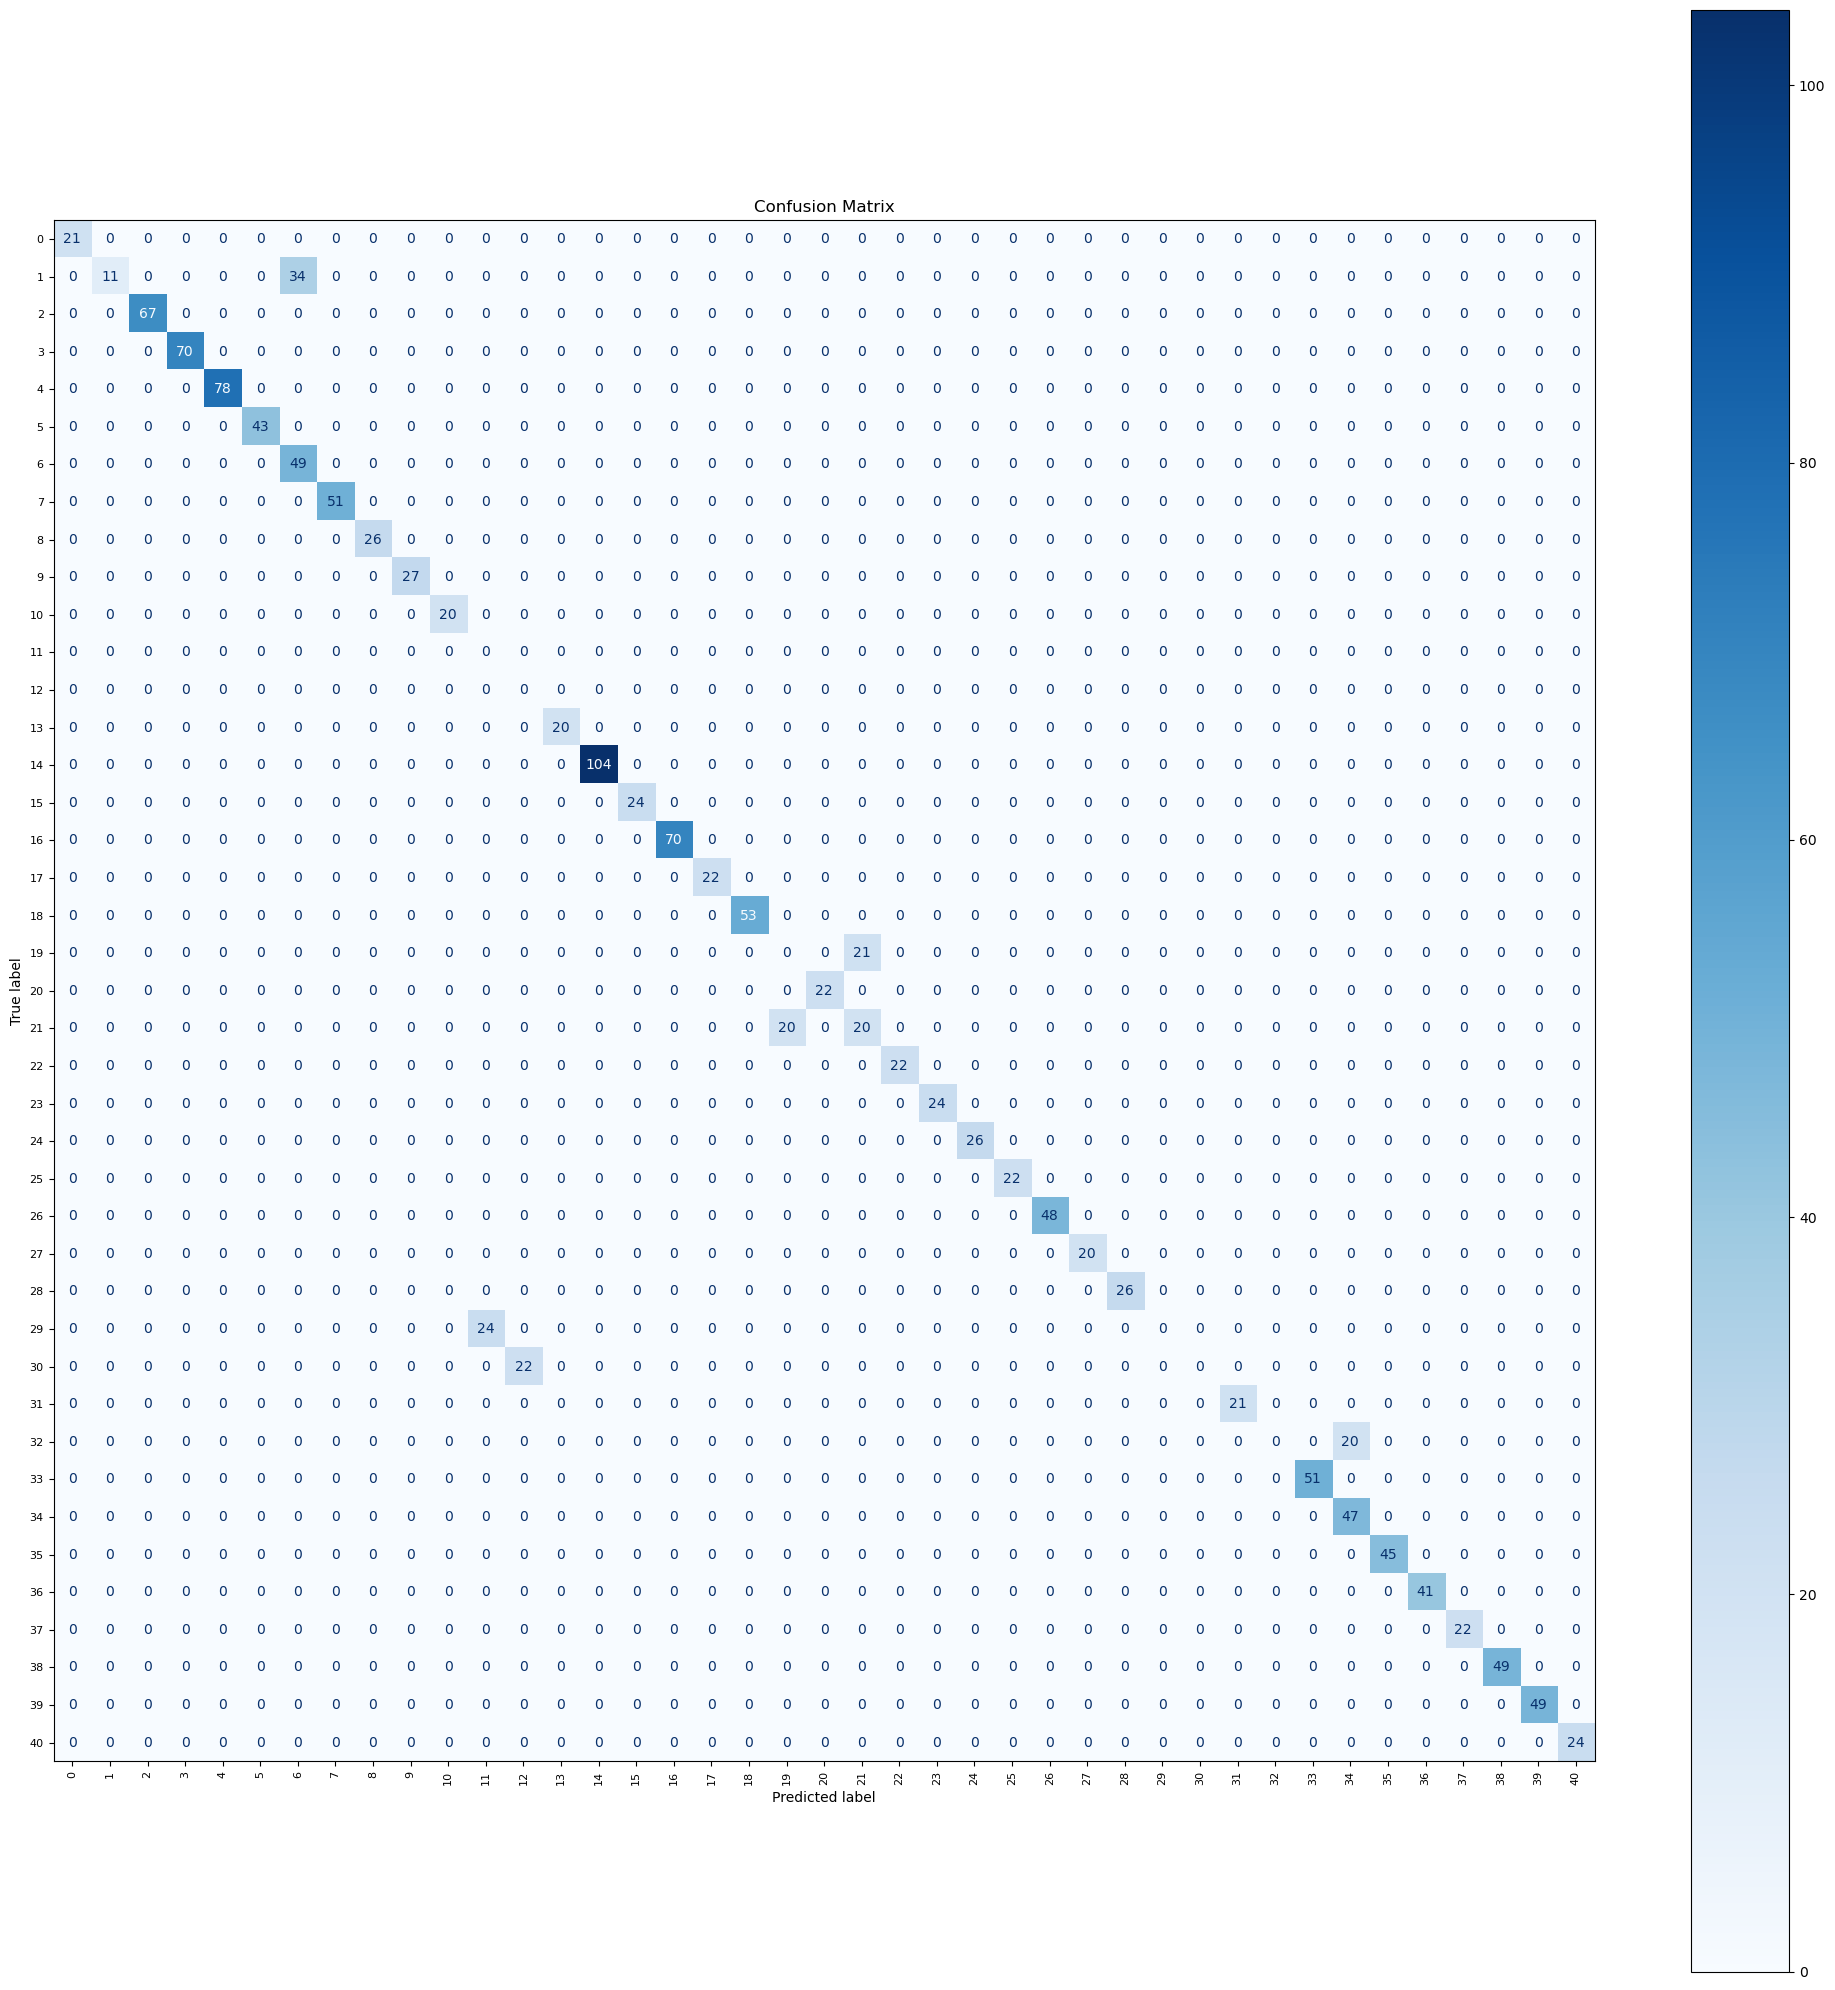

{'accuracy': 0.9044715447154471,
 'predicted_labels': array([ 0,  0,  0, ..., 59, 59, 59], dtype=int64),
 'true_labels': 86       0
 87       0
 88       0
 89       0
 90       0
         ..
 7875    59
 7876    59
 7877    59
 7878    59
 7879    59
 Name: genus_species_label, Length: 1476, dtype: int64}

In [114]:
print("---------------------------- EVALUACIÓN A NIVEL DE GÉNERO Y ESPECIE CON SMOTE -----------------------------------")
evaluate_knn_classifier(spectrum_test, genus_species_label_test, knn_genus_species_level_smote)

## Aplicando grid search en busca de los mejores híper parámetros con SMOTE

In [125]:
param_grid_for_SMOTE = {
    'n_neighbors': [3, 5, 7, ],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev'],
    'algorithm': ['auto','ball_tree', 'brute']
}

In [126]:
grid_search_for_SMOTE = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid_for_SMOTE,
    cv=4,  # Validación cruzada
    scoring='accuracy',  # Métrica principal
    verbose=3,  # Mostrar progreso
    n_jobs=-1  # Usar todos los núcleos disponibles
)

grid_search_for_SMOTE.fit(x_train_smote, genus_species_smote)

# Resultados del mejor modelo
print("Best Parameters:", grid_search_for_SMOTE.best_params_)
print("Best Cross-Validated Score:", grid_search_for_SMOTE.best_score_)

Fitting 4 folds for each of 54 candidates, totalling 216 fits
Best Parameters: {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
Best Cross-Validated Score: 1.0


In [127]:
joblib.dump(grid_search_for_SMOTE, "grid_search_knn_with_smote.pkl")

['grid_search_knn_with_smote.pkl']

In [132]:
grid_search_knn_with_smote = joblib.load('grid_search_knn_with_smote.pkl')
results = grid_search_knn_with_smote.cv_results_
results_df = pd.DataFrame(results)
results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_metric,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,2.122738,0.294869,68.433709,5.148722,auto,euclidean,3,uniform,"{'algorithm': 'auto', 'metric': 'euclidean', '...",1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1
1,2.224815,0.295657,70.053214,2.294192,auto,euclidean,3,distance,"{'algorithm': 'auto', 'metric': 'euclidean', '...",1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1
2,2.285680,0.301742,99.424693,52.977374,auto,euclidean,5,uniform,"{'algorithm': 'auto', 'metric': 'euclidean', '...",1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1
3,1.198598,0.018310,63.474324,0.249804,auto,euclidean,5,distance,"{'algorithm': 'auto', 'metric': 'euclidean', '...",1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1
4,1.218093,0.172495,66.625832,7.264978,auto,euclidean,7,uniform,"{'algorithm': 'auto', 'metric': 'euclidean', '...",1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1
5,1.344945,0.121494,77.285035,9.161960,auto,euclidean,7,distance,"{'algorithm': 'auto', 'metric': 'euclidean', '...",1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1
6,1.228670,0.028890,844.847958,19.451549,auto,manhattan,3,uniform,"{'algorithm': 'auto', 'metric': 'manhattan', '...",1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1
7,1.113979,0.029735,859.816672,41.339605,auto,manhattan,3,distance,"{'algorithm': 'auto', 'metric': 'manhattan', '...",1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1
8,1.525613,0.166450,881.282625,14.078313,auto,manhattan,5,uniform,"{'algorithm': 'auto', 'metric': 'manhattan', '...",1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1
9,1.182025,0.049187,867.759767,34.040315,auto,manhattan,5,distance,"{'algorithm': 'auto', 'metric': 'manhattan', '...",1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1


In [147]:
knn_best_smote = KNeighborsClassifier(n_neighbors=7, weights='uniform', metric='manhattan', algorithm='auto')
knn_best_smote.fit(x_train_smote, genus_species_smote)

KNeighborsClassifier(metric='manhattan', n_neighbors=7)

---------------------------- EVALUACIÓN A NIVEL DE GÉNERO Y ESPECIE CON SMOTE -----------------------------------
KNN Classifier Accuracy: 0.91

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      0.51      0.68        45
           3       1.00      1.00      1.00        67
           6       1.00      1.00      1.00        70
           7       1.00      1.00      1.00        78
           9       1.00      1.00      1.00        43
          10       0.69      1.00      0.82        49
          12       0.68      1.00      0.81        51
          15       1.00      1.00      1.00        26
          17       1.00      1.00      1.00        27
          18       1.00      1.00      1.00        20
          21       0.00      0.00      0.00         0
          22       1.00      1.00      1.00        20
          23       1.00      1.00      1.00       104
          24       1.

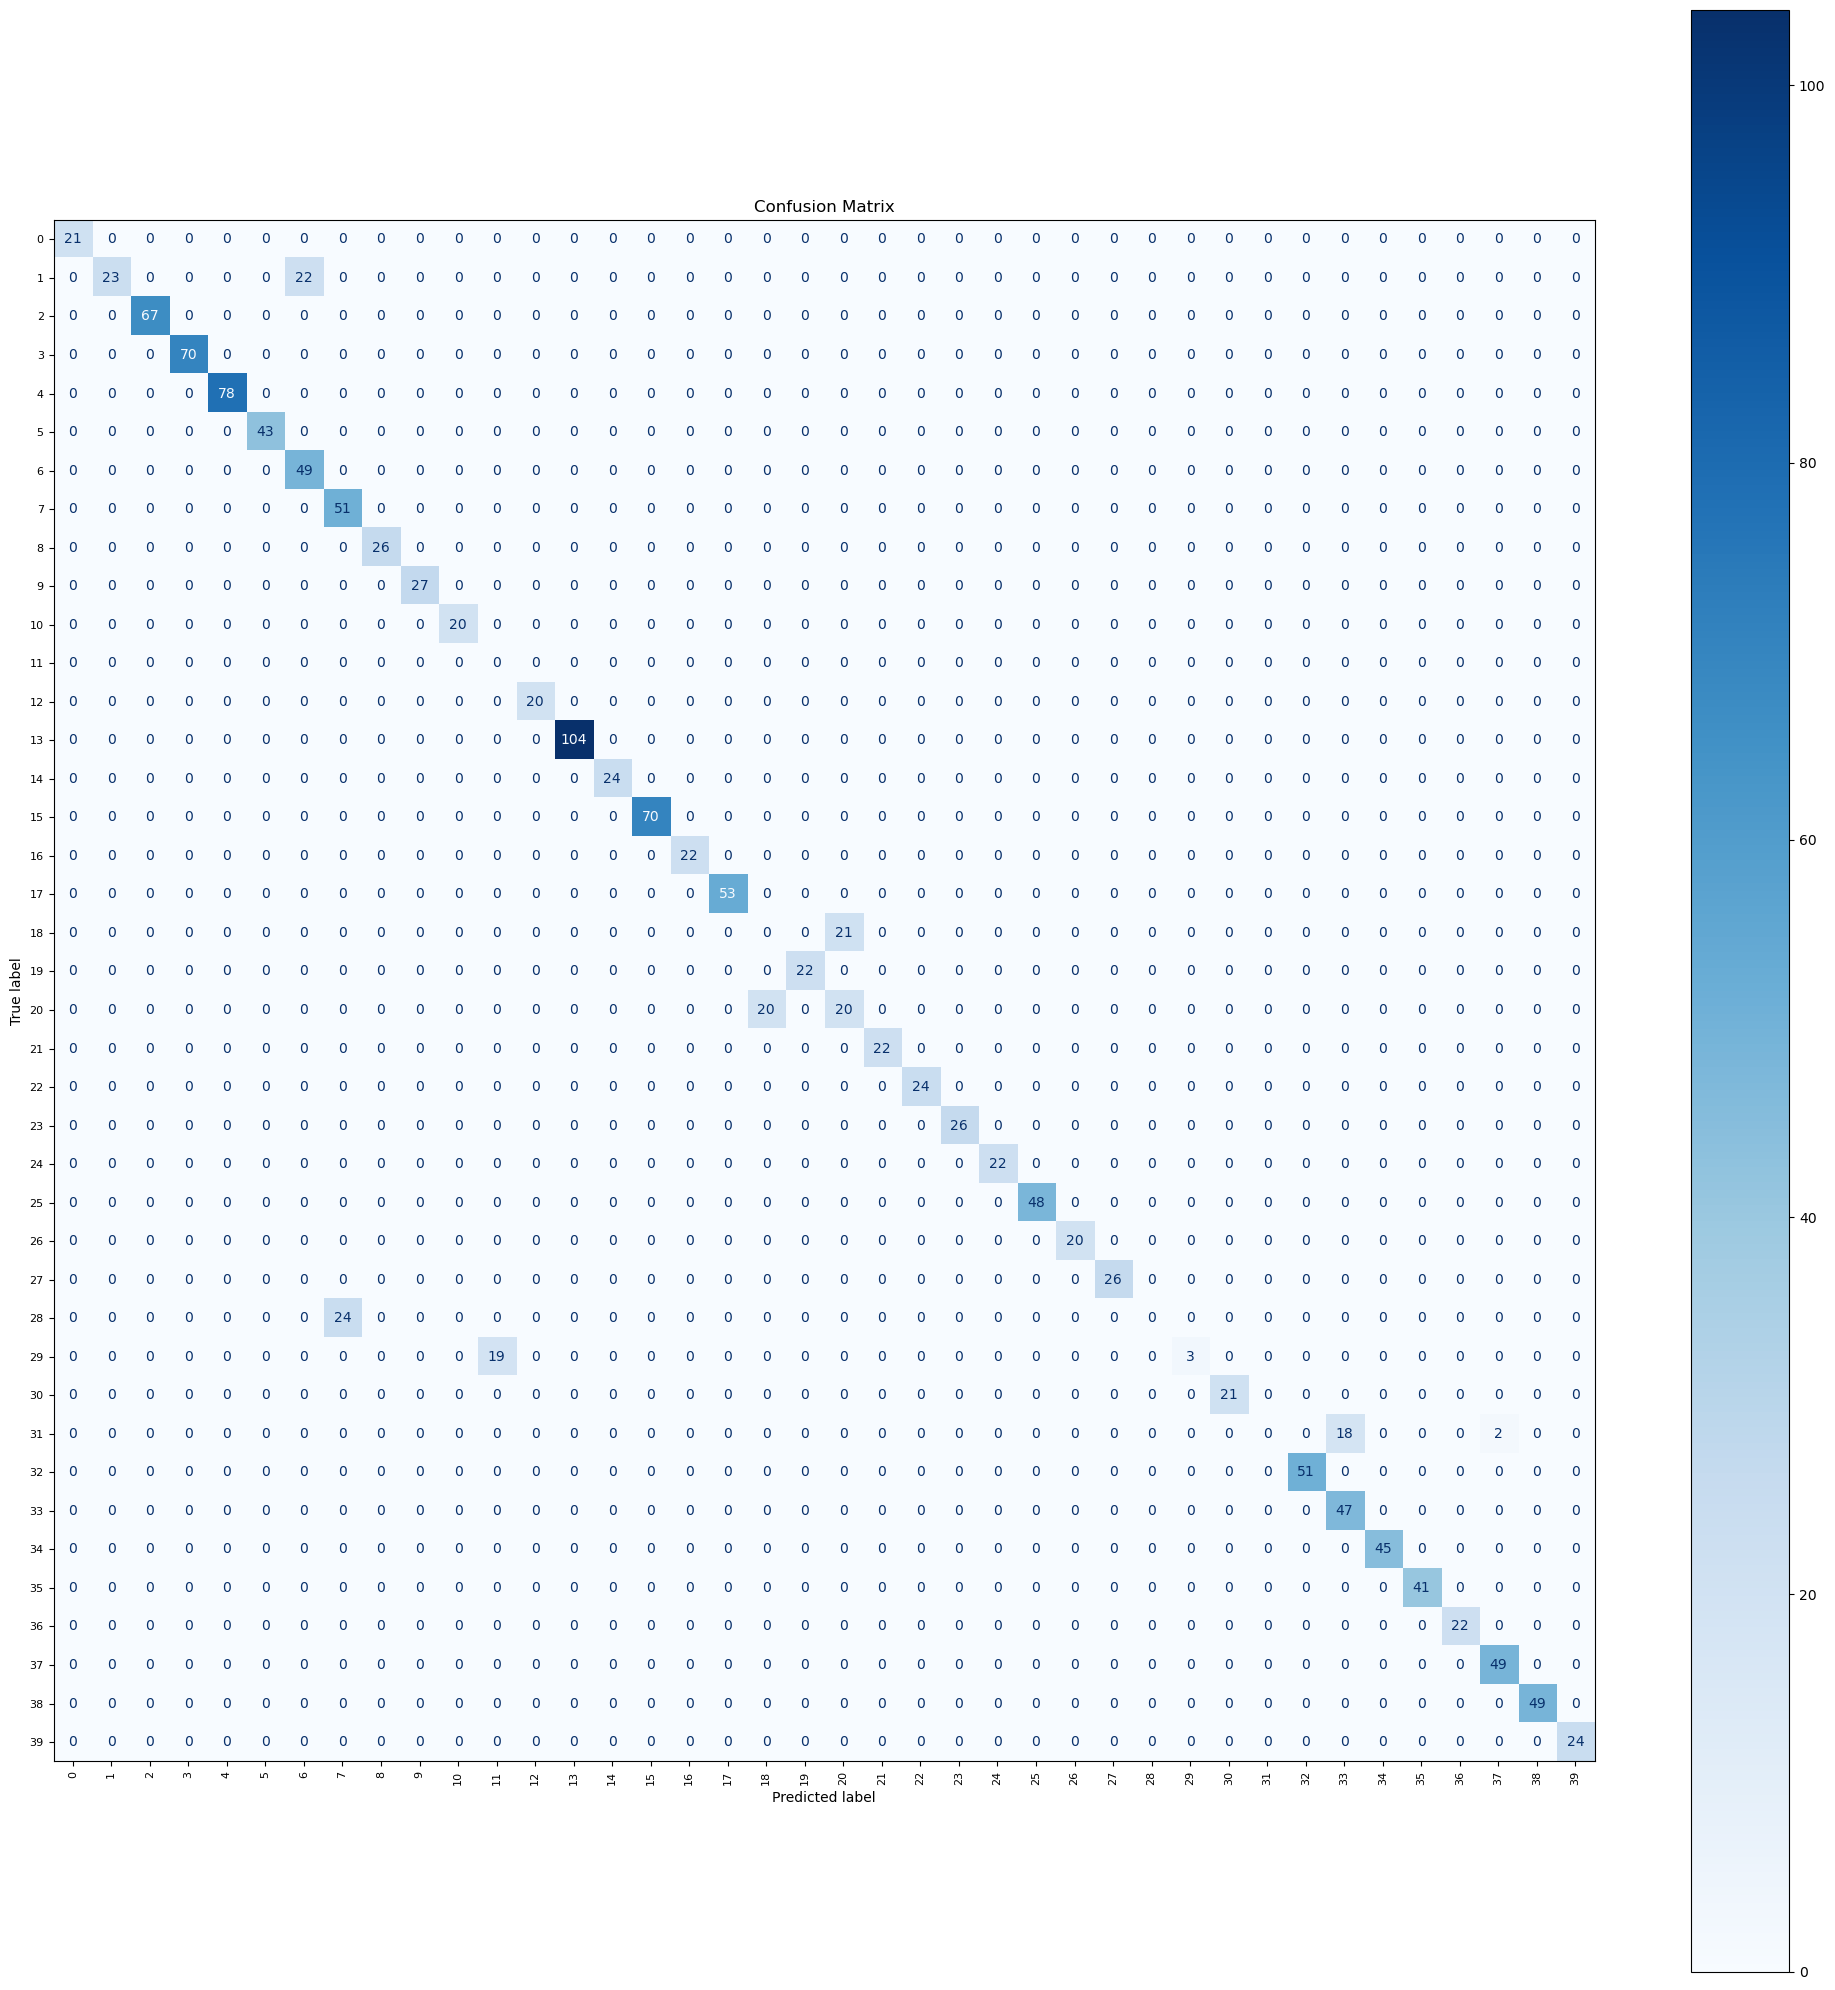

{'accuracy': 0.9146341463414634,
 'predicted_labels': array([ 0,  0,  0, ..., 59, 59, 59], dtype=int64),
 'true_labels': 86       0
 87       0
 88       0
 89       0
 90       0
         ..
 7875    59
 7876    59
 7877    59
 7878    59
 7879    59
 Name: genus_species_label, Length: 1476, dtype: int64}

In [148]:
print("---------------------------- EVALUACIÓN A NIVEL DE GÉNERO Y ESPECIE CON SMOTE -----------------------------------")
evaluate_knn_classifier(spectrum_test, genus_species_label_test, knn_best_smote)